# Chinese Produce Market Forecasting - Exploratory Data Analysis

**Author:** Bhupal Lambodhar  
**Email:** btiduwarlambodhar@sandiego.edu  
**Project:** Chinese Produce Market RMB Forecasting MLOps  

This notebook provides comprehensive exploratory data analysis of the Chinese produce market data to understand patterns, seasonality, and relationships that will inform our forecasting models.

## Data Overview
- **annex1.csv**: Item master data (251 items)
- **annex2.csv**: Sales transactions (878,503 records)
- **annex3.csv**: Wholesale prices (55,982 records)
- **annex4.csv**: Loss rates (251 items)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import yaml
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure figure size
plt.rcParams['figure.figsize'] = (12, 6)

print(" Libraries imported successfully!")
print(f" Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

 Libraries imported successfully!
 Analysis Date: 2025-06-23 15:20:29


In [2]:
# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print(" Configuration loaded:")
print(f"   Project: {config['project']['name']}")
print(f"   Author: {config['project']['author']}")
print(f"   AWS Region: {config['aws']['region']}")
print(f"   S3 Bucket: {config['aws']['s3']['bucket_name']}")

 Configuration loaded:
   Project: demand-stock-forecasting-mlops
   Author: Bhupal Lambodhar
   AWS Region: us-east-1
   S3 Bucket: sagemaker-us-east-1-346761359662


## 1. Data Loading and Initial Inspection

In [3]:
# Load raw data files
def load_data():
    """Load all raw data files"""
    data = {}
    
    try:
        # Load item master data
        data['items'] = pd.read_csv('../data/raw/annex1.csv')
        print(f" Items loaded: {len(data['items'])} records")
        
        # Load sales transactions
        data['sales'] = pd.read_csv('../data/raw/annex2.csv')
        data['sales']['DateTime'] = pd.to_datetime(
            data['sales']['Date'] + ' ' + data['sales']['Time'], errors='coerce'
        )
        data['sales']['Date'] = pd.to_datetime(data['sales']['Date'], errors='coerce')
        print(f" Sales loaded: {len(data['sales'])} transactions")
        
        # Load wholesale prices
        data['wholesale'] = pd.read_csv('../data/raw/annex3.csv')
        data['wholesale']['Date'] = pd.to_datetime(data['wholesale']['Date'], errors='coerce')
        print(f" Wholesale prices loaded: {len(data['wholesale'])} records")
        
        # Load loss rates
        data['loss_rates'] = pd.read_csv('../data/raw/annex4.csv')
        print(f" Loss rates loaded: {len(data['loss_rates'])} items")
        
    except Exception as e:
        print(f" Error loading data: {e}")
        print(" Make sure data files are in the correct location: ../data/raw/")
    
    return data

# Load the data
data = load_data()

 Items loaded: 251 records
 Sales loaded: 878503 transactions
 Wholesale prices loaded: 55982 records
 Loss rates loaded: 251 items


In [4]:
# Display basic information about each dataset
def display_data_info(data):
    """Display basic information about loaded datasets"""
    
    for name, df in data.items():
        print(f"\n🔍 {name.upper()} DATASET")
        print("="*50)
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"\nData Types:")
        print(df.dtypes)
        print(f"\nMissing Values:")
        missing = df.isnull().sum()
        missing_pct = (missing / len(df) * 100).round(2)
        missing_df = pd.DataFrame({
            'Missing Count': missing,
            'Missing %': missing_pct
        })
        print(missing_df[missing_df['Missing Count'] > 0])
        
        print(f"\nFirst 3 rows:")
        display(df.head(3))

display_data_info(data)


🔍 ITEMS DATASET
Shape: (251, 4)
Columns: ['Item Code', 'Item Name', 'Category Code', 'Category Name']

Data Types:
Item Code         int64
Item Name        object
Category Code     int64
Category Name    object
dtype: object

Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

First 3 rows:


,Item Code,Item Name,Category Code,Category Name
0,102900005115168,Niushou Shengcai,1011010101,Flower/Leaf Vegetables
1,102900005115199,Sichuan Red Cedar,1011010101,Flower/Leaf Vegetables
2,102900005115625,Local Xiaomao Cabbage,1011010101,Flower/Leaf Vegetables



🔍 SALES DATASET
Shape: (878503, 8)
Columns: ['Date', 'Time', 'Item Code', 'Quantity Sold (kilo)', 'Unit Selling Price (RMB/kg)', 'Sale or Return', 'Discount (Yes/No)', 'DateTime']

Data Types:
Date                           datetime64[ns]
Time                                   object
Item Code                               int64
Quantity Sold (kilo)                  float64
Unit Selling Price (RMB/kg)           float64
Sale or Return                         object
Discount (Yes/No)                      object
DateTime                       datetime64[ns]
dtype: object

Missing Values:
          Missing Count  Missing %
DateTime            132       0.02

First 3 rows:


,Date,Time,Item Code,Quantity Sold (kilo),Unit Selling Price (RMB/kg),Sale or Return,Discount (Yes/No),DateTime
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,sale,No,2020-07-01 09:15:07.924
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,sale,No,2020-07-01 09:17:27.295
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,sale,No,2020-07-01 09:17:33.905



🔍 WHOLESALE DATASET
Shape: (55982, 3)
Columns: ['Date', 'Item Code', 'Wholesale Price (RMB/kg)']

Data Types:
Date                        datetime64[ns]
Item Code                            int64
Wholesale Price (RMB/kg)           float64
dtype: object

Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

First 3 rows:


,Date,Item Code,Wholesale Price (RMB/kg)
0,2020-07-01,102900005115762,3.88
1,2020-07-01,102900005115779,6.72
2,2020-07-01,102900005115786,3.19



🔍 LOSS_RATES DATASET
Shape: (251, 3)
Columns: ['Item Code', 'Item Name', 'Loss Rate (%)']

Data Types:
Item Code          int64
Item Name         object
Loss Rate (%)    float64
dtype: object

Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

First 3 rows:


,Item Code,Item Name,Loss Rate (%)
0,102900005115168,Niushou Shengcai,4.39
1,102900005115199,Sichuan Red Cedar,10.46
2,102900005115250,Xixia Black Mushroom (1),10.80


## 2. Data Quality Assessment

In [5]:
# Data quality metrics
def assess_data_quality(data):
    """Assess data quality across all datasets"""
    
    quality_summary = {}
    
    for name, df in data.items():
        quality_metrics = {
            'total_records': len(df),
            'total_columns': len(df.columns),
            'duplicate_rows': df.duplicated().sum(),
            'missing_data_pct': (df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100).round(2),
            'unique_items': df['Item Code'].nunique() if 'Item Code' in df.columns else 'N/A'
        }
        
        # Date range for time-series data
        if 'Date' in df.columns:
            date_col = df['Date'].dropna()
            if len(date_col) > 0:
                quality_metrics['date_range'] = f"{date_col.min().strftime('%Y-%m-%d')} to {date_col.max().strftime('%Y-%m-%d')}"
                quality_metrics['date_span_days'] = (date_col.max() - date_col.min()).days
        
        quality_summary[name] = quality_metrics
    
    # Create quality summary DataFrame
    quality_df = pd.DataFrame(quality_summary).T
    return quality_df

quality_summary = assess_data_quality(data)
print(" DATA QUALITY SUMMARY")
print("="*60)
display(quality_summary)

 DATA QUALITY SUMMARY


,total_records,total_columns,duplicate_rows,missing_data_pct,unique_items,date_range,date_span_days
items,251.0,4.0,0.0,0.0,251.0,NaN,NaN
sales,878503,8,0,0.0,246,2020-07-01 to 2023-06-30,1094
wholesale,55982,3,0,0.0,251,2020-07-01 to 2023-06-30,1094
loss_rates,251.0,3.0,0.0,0.0,251.0,NaN,NaN


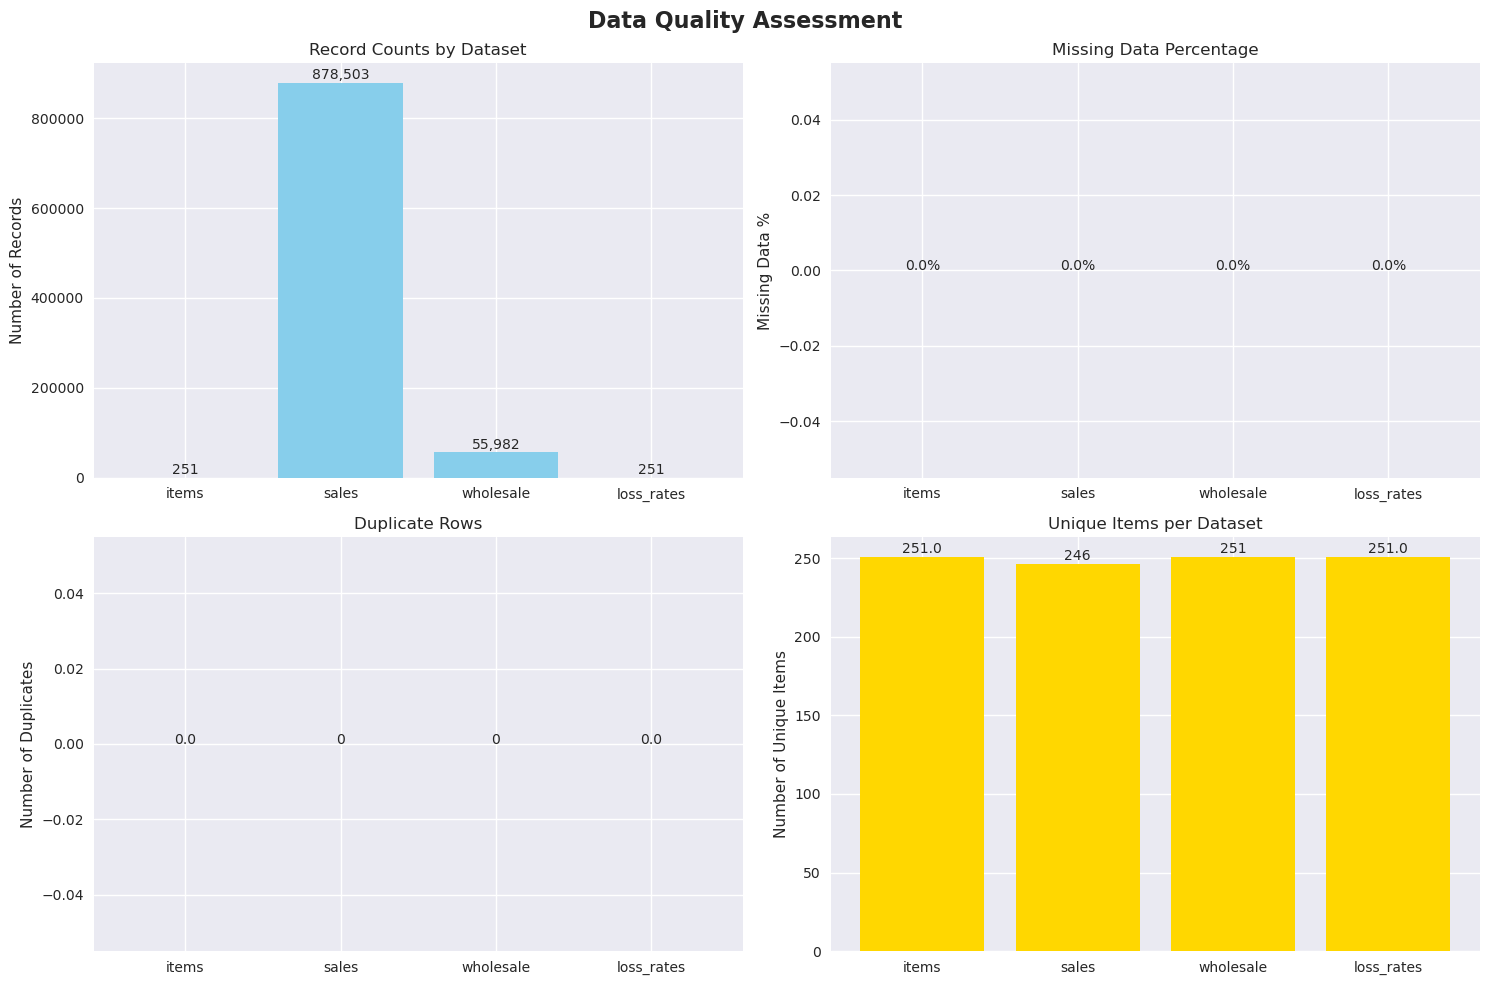

In [6]:
# Visualize data quality metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Data Quality Assessment', fontsize=16, fontweight='bold')

# 1. Record counts
datasets = list(data.keys())
record_counts = [len(data[name]) for name in datasets]
axes[0, 0].bar(datasets, record_counts, color='skyblue')
axes[0, 0].set_title('Record Counts by Dataset')
axes[0, 0].set_ylabel('Number of Records')
for i, v in enumerate(record_counts):
    axes[0, 0].text(i, v + max(record_counts)*0.01, f'{v:,}', ha='center')

# 2. Missing data percentages
missing_pcts = [quality_summary.loc[name, 'missing_data_pct'] for name in datasets]
axes[0, 1].bar(datasets, missing_pcts, color='lightcoral')
axes[0, 1].set_title('Missing Data Percentage')
axes[0, 1].set_ylabel('Missing Data %')
for i, v in enumerate(missing_pcts):
    axes[0, 1].text(i, v + max(missing_pcts)*0.01, f'{v}%', ha='center')

# 3. Duplicate rows
duplicate_counts = [quality_summary.loc[name, 'duplicate_rows'] for name in datasets]
axes[1, 0].bar(datasets, duplicate_counts, color='lightgreen')
axes[1, 0].set_title('Duplicate Rows')
axes[1, 0].set_ylabel('Number of Duplicates')
for i, v in enumerate(duplicate_counts):
    axes[1, 0].text(i, v + max(duplicate_counts)*0.01, f'{v}', ha='center')

# 4. Unique items
unique_items = [quality_summary.loc[name, 'unique_items'] for name in datasets if quality_summary.loc[name, 'unique_items'] != 'N/A']
datasets_with_items = [name for name in datasets if quality_summary.loc[name, 'unique_items'] != 'N/A']
axes[1, 1].bar(datasets_with_items, unique_items, color='gold')
axes[1, 1].set_title('Unique Items per Dataset')
axes[1, 1].set_ylabel('Number of Unique Items')
for i, v in enumerate(unique_items):
    axes[1, 1].text(i, v + max(unique_items)*0.01, f'{v}', ha='center')

plt.tight_layout()
plt.show()

## 3. Item Categories Analysis

 ITEM CATEGORIES ANALYSIS

Total Categories: 6
Total Items: 251

Top 10 Categories by Item Count:
Category Name
Flower/Leaf Vegetables         100
Edible Mushroom                 72
Capsicum                        45
Aquatic Tuberous Vegetables     19
Solanum                         10
Cabbage                          5
Name: count, dtype: int64


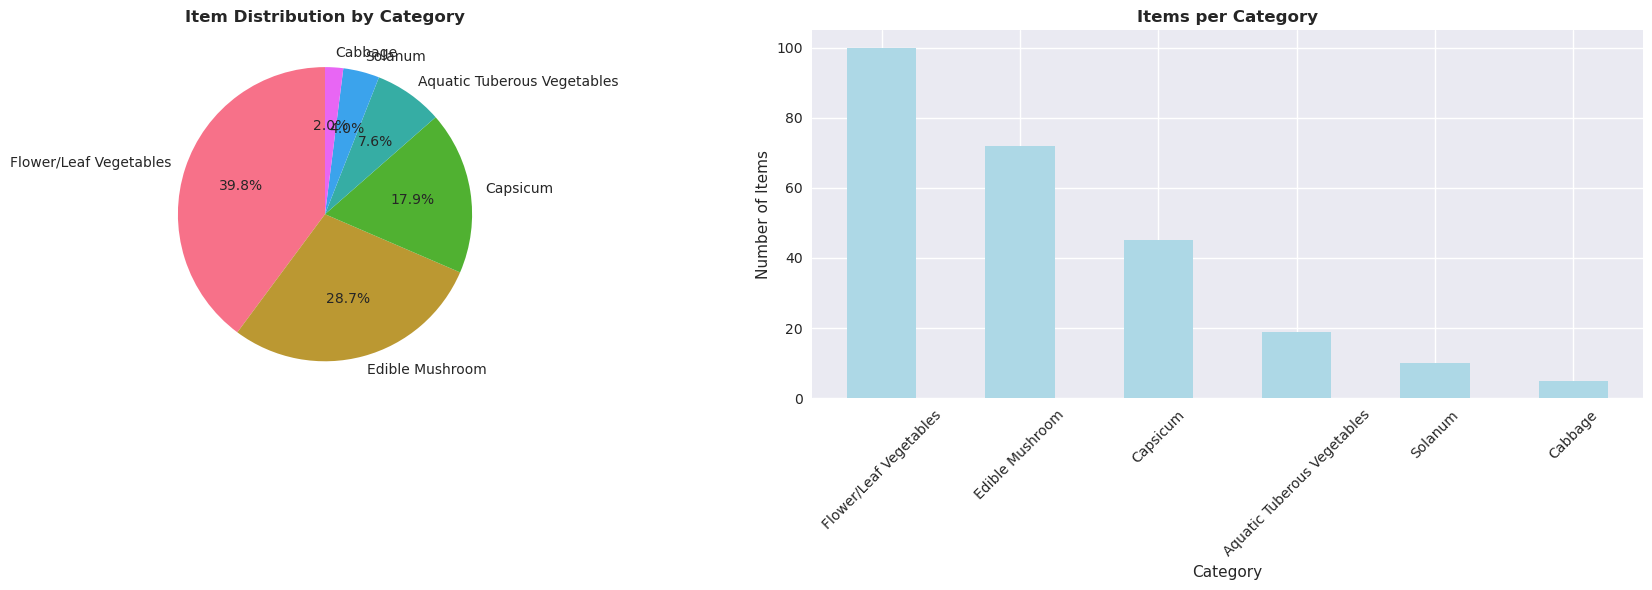

In [7]:
# Analyze item categories
if 'items' in data:
    items_df = data['items']
    
    print(" ITEM CATEGORIES ANALYSIS")
    print("="*50)
    
    # Category distribution
    category_counts = items_df['Category Name'].value_counts()
    print(f"\nTotal Categories: {items_df['Category Name'].nunique()}")
    print(f"Total Items: {len(items_df)}")
    print("\nTop 10 Categories by Item Count:")
    print(category_counts.head(10))
    
    # Visualize category distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Pie chart for top categories
    top_categories = category_counts.head(8)
    others_count = category_counts.iloc[8:].sum()
    if others_count > 0:
        plot_data = pd.concat([top_categories, pd.Series({'Others': others_count})])
    else:
        plot_data = top_categories
    
    ax1.pie(plot_data.values, labels=plot_data.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Item Distribution by Category', fontweight='bold')
    
    # Bar chart for all categories
    category_counts.plot(kind='bar', ax=ax2, color='lightblue')
    ax2.set_title('Items per Category', fontweight='bold')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Number of Items')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## 4. Sales Transaction Analysis

In [8]:
# Analyze sales transactions
if 'sales' in data:
    sales_df = data['sales'].copy()
    
    print(" SALES TRANSACTIONS ANALYSIS")
    print("="*50)
    
    # Basic statistics
    print(f"Total Transactions: {len(sales_df):,}")
    print(f"Date Range: {sales_df['Date'].min()} to {sales_df['Date'].max()}")
    print(f"Unique Items: {sales_df['Item Code'].nunique():,}")
    
    # Sales vs Returns
    transaction_types = sales_df['Sale or Return'].value_counts()
    print(f"\nTransaction Types:")
    for txn_type, count in transaction_types.items():
        pct = (count / len(sales_df) * 100)
        print(f"  {txn_type}: {count:,} ({pct:.1f}%)")
    
    # Discount analysis
    discount_analysis = sales_df['Discount (Yes/No)'].value_counts()
    print(f"\nDiscount Analysis:")
    for discount, count in discount_analysis.items():
        pct = (count / len(sales_df) * 100)
        print(f"  {discount}: {count:,} ({pct:.1f}%)")
    
    # Price and quantity statistics
    print(f"\nPrice Statistics (RMB/kg):")
    price_stats = sales_df['Unit Selling Price (RMB/kg)'].describe()
    for stat, value in price_stats.items():
        print(f"  {stat}: {value:.2f}")
    
    print(f"\nQuantity Statistics (kg):")
    qty_stats = sales_df['Quantity Sold (kilo)'].describe()
    for stat, value in qty_stats.items():
        print(f"  {stat}: {value:.2f}")

 SALES TRANSACTIONS ANALYSIS
Total Transactions: 878,503
Date Range: 2020-07-01 00:00:00 to 2023-06-30 00:00:00
Unique Items: 246

Transaction Types:
  sale: 878,042 (99.9%)
  return: 461 (0.1%)

Discount Analysis:
  No: 831,137 (94.6%)
  Yes: 47,366 (5.4%)

Price Statistics (RMB/kg):
  count: 878503.00
  mean: 8.92
  std: 6.31
  min: 0.10
  25%: 4.90
  50%: 7.90
  75%: 10.80
  max: 119.90

Quantity Statistics (kg):
  count: 878503.00
  mean: 0.54
  std: 0.40
  min: -9.08
  25%: 0.29
  50%: 0.43
  75%: 0.74
  max: 160.00


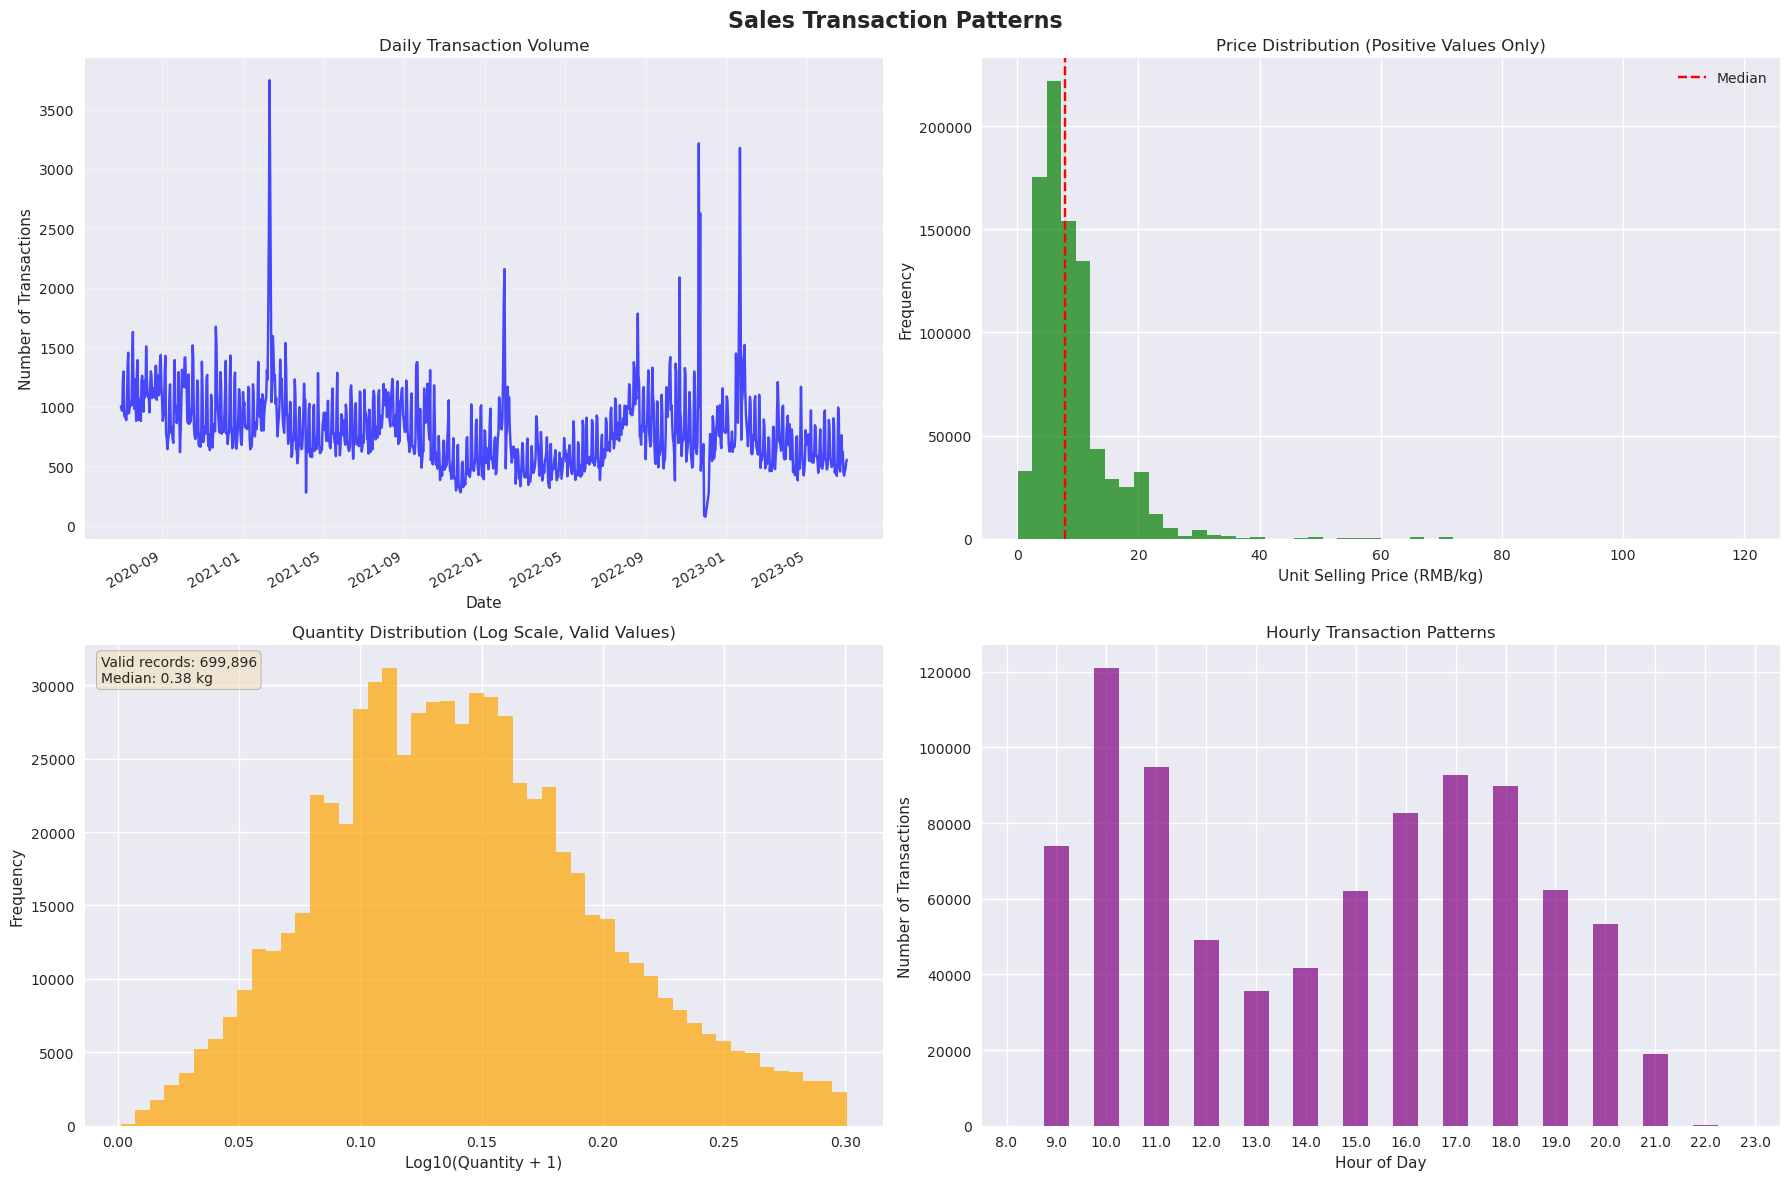

 QUANTITY DATA QUALITY SUMMARY
Total records: 878,503
Zero quantities: 0 (0.00%)
Negative quantities: 461 (0.05%)
Valid positive quantities: 699,896 (79.67%)
  Found 461 negative quantities - these might be returns or data errors


In [9]:
# Visualize sales patterns
if 'sales' in data:
    sales_df = data['sales'].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Sales Transaction Patterns', fontsize=16, fontweight='bold')
    
    # 1. Daily transaction volume
    daily_transactions = sales_df.groupby('Date').size()
    daily_transactions.plot(ax=axes[0, 0], color='blue', alpha=0.7)
    axes[0, 0].set_title('Daily Transaction Volume')
    axes[0, 0].set_ylabel('Number of Transactions')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Price distribution
    # Filter out negative or zero prices for visualization
    valid_prices = sales_df['Unit Selling Price (RMB/kg)'][sales_df['Unit Selling Price (RMB/kg)'] > 0]
    valid_prices.hist(bins=50, ax=axes[0, 1], color='green', alpha=0.7)
    axes[0, 1].set_title('Price Distribution (Positive Values Only)')
    axes[0, 1].set_xlabel('Unit Selling Price (RMB/kg)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(valid_prices.median(), 
                      color='red', linestyle='--', label='Median')
    axes[0, 1].legend()
    
    # 3. Quantity distribution
    # Filter out negative, zero, or extremely large quantities for better visualization
    valid_quantities = sales_df['Quantity Sold (kilo)']
    valid_quantities = valid_quantities[(valid_quantities > 0) & (valid_quantities < valid_quantities.quantile(0.95))]
    
    if len(valid_quantities) > 0:
        # Log scale for better visualization
        log_quantities = np.log10(valid_quantities + 1)
        log_quantities.hist(bins=50, ax=axes[1, 0], color='orange', alpha=0.7)
        axes[1, 0].set_title('Quantity Distribution (Log Scale, Valid Values)')
        axes[1, 0].set_xlabel('Log10(Quantity + 1)')
        axes[1, 0].set_ylabel('Frequency')
        
        # Add some statistics as text
        axes[1, 0].text(0.02, 0.98, f'Valid records: {len(valid_quantities):,}\nMedian: {valid_quantities.median():.2f} kg', 
                       transform=axes[1, 0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        axes[1, 0].text(0.5, 0.5, 'No valid quantity data to display', 
                       transform=axes[1, 0].transAxes, ha='center', va='center')
        axes[1, 0].set_title('Quantity Distribution - No Valid Data')
    
    # 4. Hourly transaction patterns
    # Check if DateTime column exists and has valid data
    if 'DateTime' in sales_df.columns and sales_df['DateTime'].notna().sum() > 0:
        sales_df['Hour'] = sales_df['DateTime'].dt.hour
        hourly_transactions = sales_df.groupby('Hour').size()
        hourly_transactions.plot(kind='bar', ax=axes[1, 1], color='purple', alpha=0.7)
        axes[1, 1].set_title('Hourly Transaction Patterns')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Number of Transactions')
        axes[1, 1].tick_params(axis='x', rotation=0)
    else:
        axes[1, 1].text(0.5, 0.5, 'DateTime data not available', 
                       transform=axes[1, 1].transAxes, ha='center', va='center')
        axes[1, 1].set_title('Hourly Patterns - Data Not Available')
    
    plt.tight_layout()
    plt.show()
    
    # Print data quality summary for quantities
    print(" QUANTITY DATA QUALITY SUMMARY")
    print("="*50)
    total_records = len(sales_df)
    zero_quantities = (sales_df['Quantity Sold (kilo)'] == 0).sum()
    negative_quantities = (sales_df['Quantity Sold (kilo)'] < 0).sum()
    valid_quantities_count = len(valid_quantities)
    
    print(f"Total records: {total_records:,}")
    print(f"Zero quantities: {zero_quantities:,} ({zero_quantities/total_records*100:.2f}%)")
    print(f"Negative quantities: {negative_quantities:,} ({negative_quantities/total_records*100:.2f}%)")
    print(f"Valid positive quantities: {valid_quantities_count:,} ({valid_quantities_count/total_records*100:.2f}%)")
    
    if negative_quantities > 0:
        print(f"  Found {negative_quantities} negative quantities - these might be returns or data errors")
    if zero_quantities > 0:
        print(f"  Found {zero_quantities} zero quantities - these might be promotional items or data errors")

## 5. Wholesale Price Analysis

In [10]:
# Analyze wholesale prices
if 'wholesale' in data:
    wholesale_df = data['wholesale'].copy()
    
    print(" WHOLESALE PRICE ANALYSIS")
    print("="*50)
    
    print(f"Total Price Records: {len(wholesale_df):,}")
    print(f"Date Range: {wholesale_df['Date'].min()} to {wholesale_df['Date'].max()}")
    print(f"Unique Items: {wholesale_df['Item Code'].nunique():,}")
    
    # Wholesale price statistics
    print(f"\nWholesale Price Statistics (RMB/kg):")
    price_stats = wholesale_df['Wholesale Price (RMB/kg)'].describe()
    for stat, value in price_stats.items():
        print(f"  {stat}: {value:.2f}")
    
    # Top items by average wholesale price
    if 'items' in data:
        wholesale_with_names = wholesale_df.merge(
            data['items'][['Item Code', 'Item Name']], 
            on='Item Code', 
            how='left'
        )
        
        avg_prices = wholesale_with_names.groupby(['Item Code', 'Item Name'])['Wholesale Price (RMB/kg)'].mean().sort_values(ascending=False)
        print(f"\nTop 10 Most Expensive Items (Average Wholesale Price):")
        for (item_code, item_name), price in avg_prices.head(10).items():
            print(f"  {item_name}: {price:.2f} RMB/kg")

 WHOLESALE PRICE ANALYSIS
Total Price Records: 55,982
Date Range: 2020-07-01 00:00:00 to 2023-06-30 00:00:00
Unique Items: 251

Wholesale Price Statistics (RMB/kg):
  count: 55982.00
  mean: 5.96
  std: 5.07
  min: 0.01
  25%: 2.81
  50%: 4.63
  75%: 7.57
  max: 141.00

Top 10 Most Expensive Items (Average Wholesale Price):
  Hongshan Gift Box: 141.00 RMB/kg
  Chicken Fir Bacteria: 80.00 RMB/kg
  Hongshan Shoutidai: 73.50 RMB/kg
  Black Porcini: 64.41 RMB/kg
  Black Chicken  Mushroom: 62.79 RMB/kg
  Huanghuacai: 55.31 RMB/kg
  Malan Head: 29.98 RMB/kg
  Sichuan Red Cedar: 25.98 RMB/kg
  Chopped Red Pine: 23.47 RMB/kg
  Honghu Lotus Root: 22.01 RMB/kg


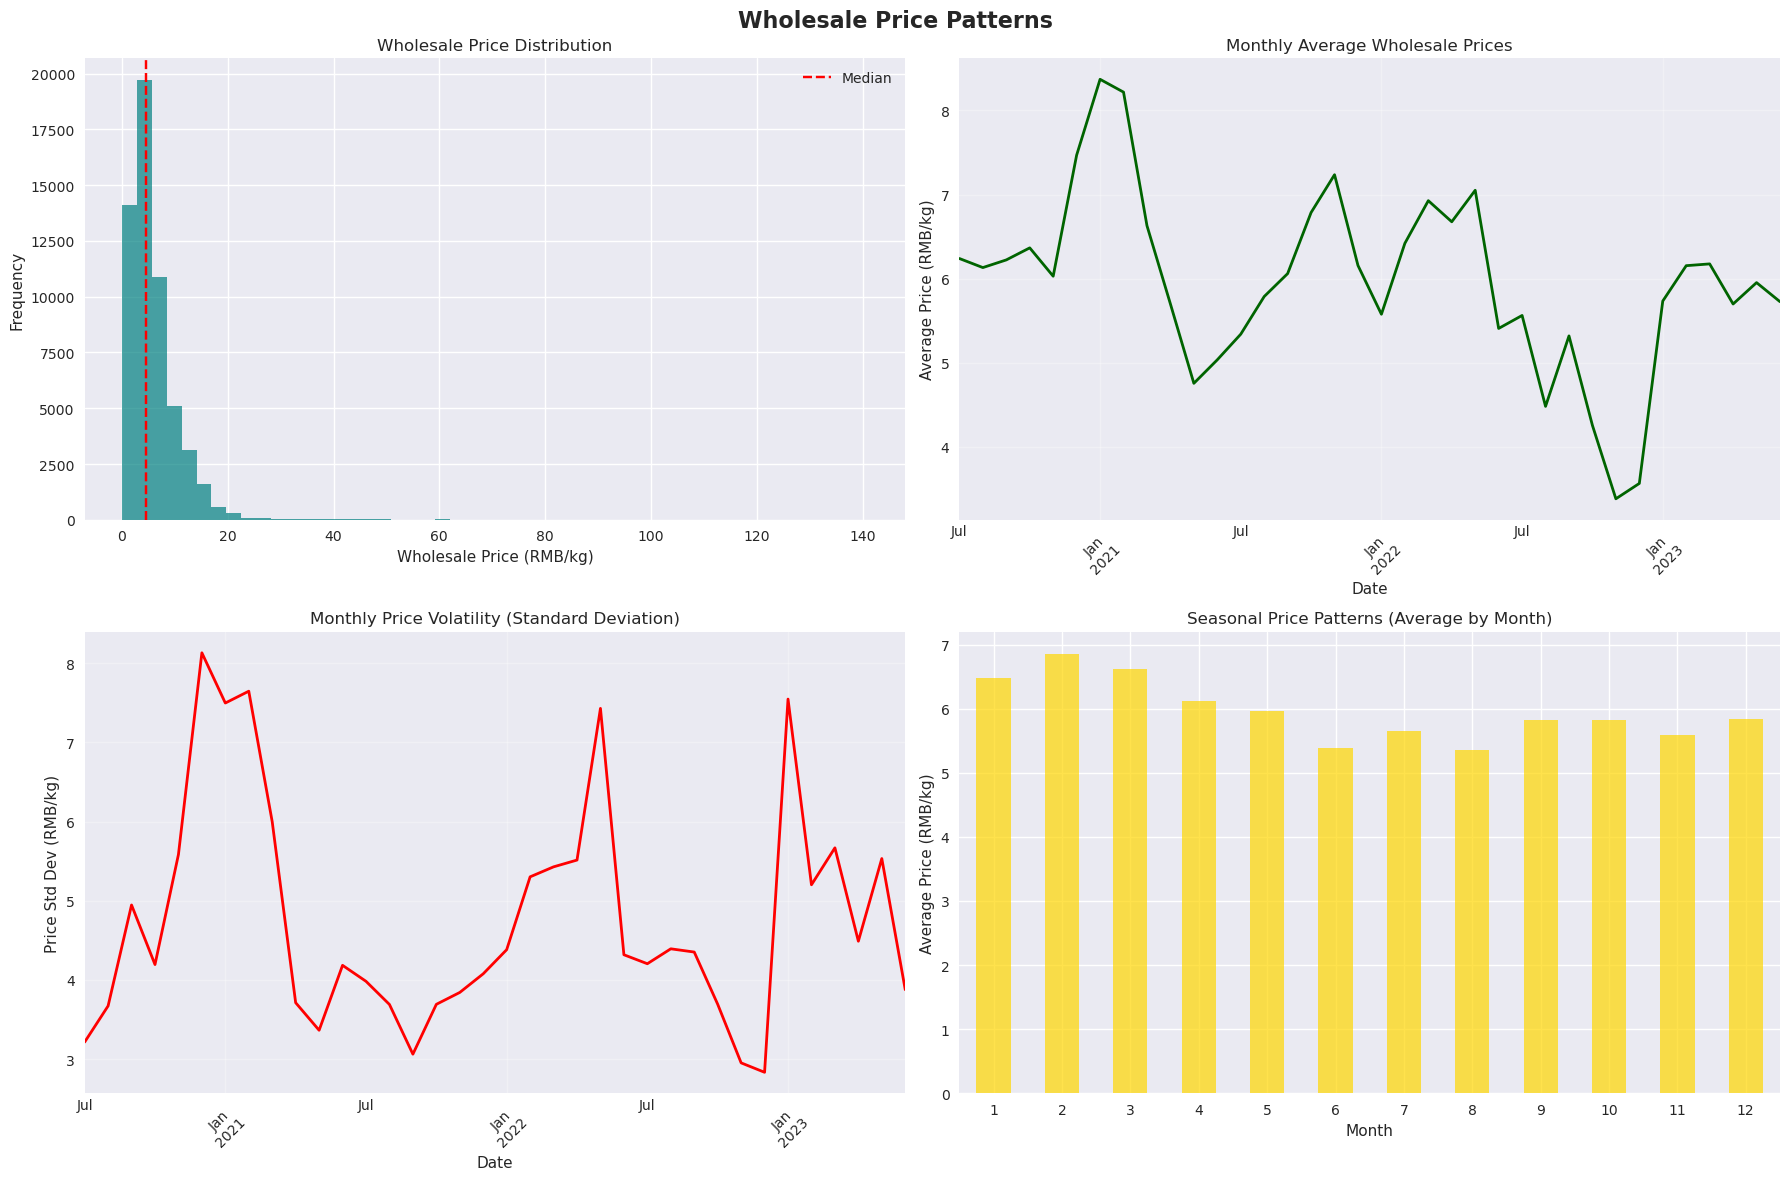

In [11]:
# Visualize wholesale price patterns
if 'wholesale' in data:
    wholesale_df = data['wholesale'].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Wholesale Price Patterns', fontsize=16, fontweight='bold')
    
    # 1. Price distribution
    wholesale_df['Wholesale Price (RMB/kg)'].hist(bins=50, ax=axes[0, 0], color='teal', alpha=0.7)
    axes[0, 0].set_title('Wholesale Price Distribution')
    axes[0, 0].set_xlabel('Wholesale Price (RMB/kg)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(wholesale_df['Wholesale Price (RMB/kg)'].median(), 
                      color='red', linestyle='--', label='Median')
    axes[0, 0].legend()
    
    # 2. Price trends over time
    monthly_avg_prices = wholesale_df.groupby(wholesale_df['Date'].dt.to_period('M'))['Wholesale Price (RMB/kg)'].mean()
    monthly_avg_prices.plot(ax=axes[0, 1], color='darkgreen', linewidth=2)
    axes[0, 1].set_title('Monthly Average Wholesale Prices')
    axes[0, 1].set_ylabel('Average Price (RMB/kg)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Price volatility by month
    monthly_price_std = wholesale_df.groupby(wholesale_df['Date'].dt.to_period('M'))['Wholesale Price (RMB/kg)'].std()
    monthly_price_std.plot(ax=axes[1, 0], color='red', linewidth=2)
    axes[1, 0].set_title('Monthly Price Volatility (Standard Deviation)')
    axes[1, 0].set_ylabel('Price Std Dev (RMB/kg)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Seasonal price patterns
    wholesale_df['Month'] = wholesale_df['Date'].dt.month
    seasonal_prices = wholesale_df.groupby('Month')['Wholesale Price (RMB/kg)'].mean()
    seasonal_prices.plot(kind='bar', ax=axes[1, 1], color='gold', alpha=0.7)
    axes[1, 1].set_title('Seasonal Price Patterns (Average by Month)')
    axes[1, 1].set_xlabel('Month')
    axes[1, 1].set_ylabel('Average Price (RMB/kg)')
    axes[1, 1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

## 6. Loss Rate Analysis

In [12]:
# Analyze loss rates
if 'loss_rates' in data:
    loss_df = data['loss_rates'].copy()
    
    print(" LOSS RATE ANALYSIS")
    print("="*50)
    
    print(f"Total Items with Loss Data: {len(loss_df)}")
    
    # Loss rate statistics
    print(f"\nLoss Rate Statistics (%):")
    loss_stats = loss_df['Loss Rate (%)'].describe()
    for stat, value in loss_stats.items():
        print(f"  {stat}: {value:.2f}%")
    
    # Categorize loss rates
    loss_df['Loss Category'] = pd.cut(
        loss_df['Loss Rate (%)'],
        bins=[0, 5, 15, 25, 100],
        labels=['Low (0-5%)', 'Medium (5-15%)', 'High (15-25%)', 'Very High (>25%)']
    )
    
    loss_category_counts = loss_df['Loss Category'].value_counts()
    print(f"\nLoss Rate Categories:")
    for category, count in loss_category_counts.items():
        pct = (count / len(loss_df) * 100)
        print(f"  {category}: {count} items ({pct:.1f}%)")
    
    # Items with highest loss rates
    high_loss_items = loss_df.nlargest(10, 'Loss Rate (%)')
    print(f"\nTop 10 Items with Highest Loss Rates:")
    for _, row in high_loss_items.iterrows():
        print(f"  {row['Item Name']}: {row['Loss Rate (%)']:.2f}%")

 LOSS RATE ANALYSIS
Total Items with Loss Data: 251

Loss Rate Statistics (%):
  count: 251.00%
  mean: 9.43%
  std: 5.21%
  min: 0.00%
  25%: 8.22%
  50%: 9.43%
  75%: 11.13%
  max: 29.25%

Loss Rate Categories:
  Medium (5-15%): 185 items (73.7%)
  High (15-25%): 24 items (9.6%)
  Low (0-5%): 15 items (6.0%)
  Very High (>25%): 5 items (2.0%)

Top 10 Items with Highest Loss Rates:
  High Melon (1): 29.25%
  Chuncai: 29.03%
  Dongmenkou Xiaobaicai: 27.84%
  Foreign Garland Chrysanthemum : 26.16%
  Purple Cabbage (1): 25.53%
  Honghu Lotus Root: 24.05%
  Chinese Cabbage: 22.27%
  Kuaicai: 20.38%
  The Steak Mushrooms (Box): 19.80%
  Purple Beicai: 19.58%


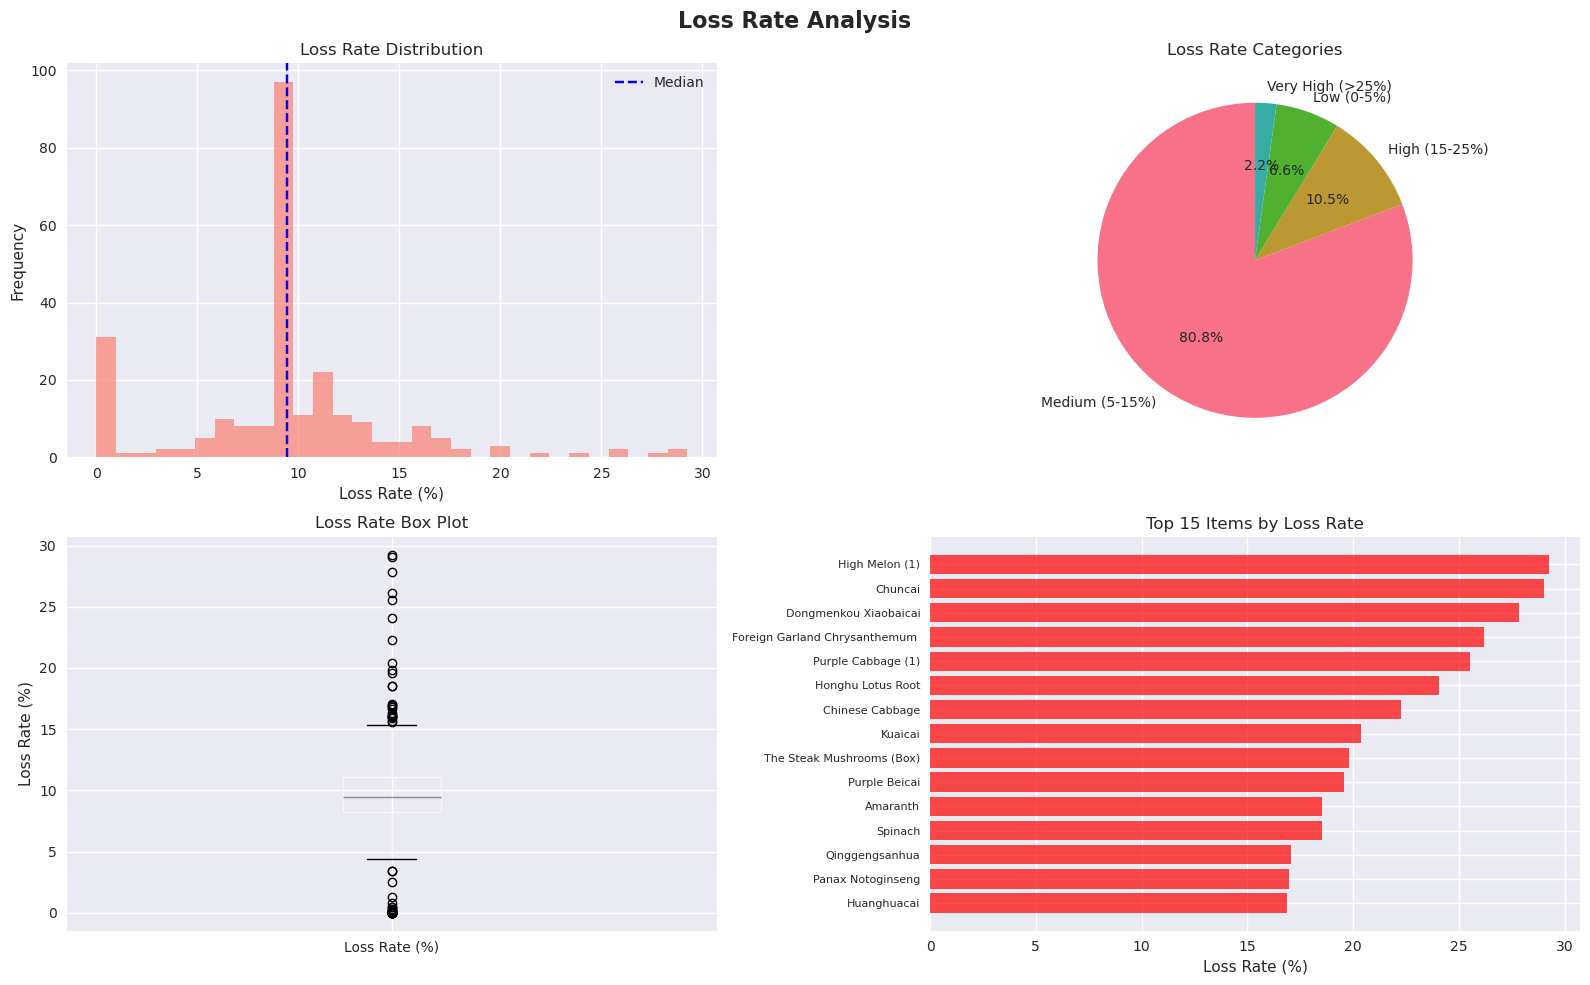

📉 LOSS RATE ANALYSIS SUMMARY
Total items analyzed: 251
Average loss rate: 9.43%
Median loss rate: 9.43%
Min loss rate: 0.00%
Max loss rate: 29.25%

Loss Rate Distribution:
  Medium (5-15%): 185 items (73.7%)
  High (15-25%): 24 items (9.6%)
  Low (0-5%): 15 items (6.0%)
  Very High (>25%): 5 items (2.0%)

Top 5 Highest Loss Rate Items:
  1. High Melon (1): 29.25%
  2. Chuncai: 29.03%
  3. Dongmenkou Xiaobaicai: 27.84%
  4. Foreign Garland Chrysanthemum : 26.16%
  5. Purple Cabbage (1): 25.53%


In [13]:
# Visualize loss rate patterns
if 'loss_rates' in data:
    loss_df = data['loss_rates'].copy()
    
    # Create loss rate categories (since they don't exist in raw data)
    loss_df['Loss_Rate_Category'] = pd.cut(
        loss_df['Loss Rate (%)'],
        bins=[0, 5, 15, 25, 100],
        labels=['Low (0-5%)', 'Medium (5-15%)', 'High (15-25%)', 'Very High (>25%)']
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Loss Rate Analysis', fontsize=16, fontweight='bold')
    
    # 1. Loss rate distribution
    loss_df['Loss Rate (%)'].hist(bins=30, ax=axes[0, 0], color='salmon', alpha=0.7)
    axes[0, 0].set_title('Loss Rate Distribution')
    axes[0, 0].set_xlabel('Loss Rate (%)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(loss_df['Loss Rate (%)'].median(), 
                      color='blue', linestyle='--', label='Median')
    axes[0, 0].legend()
    
    # 2. Loss rate categories pie chart
    loss_category_counts = loss_df['Loss_Rate_Category'].value_counts()
    axes[0, 1].pie(loss_category_counts.values, labels=loss_category_counts.index, 
                   autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Loss Rate Categories')
    
    # 3. Box plot of loss rates
    loss_df.boxplot(column='Loss Rate (%)', ax=axes[1, 0])
    axes[1, 0].set_title('Loss Rate Box Plot')
    axes[1, 0].set_ylabel('Loss Rate (%)')
    
    # 4. Top 15 items with highest loss rates
    top_loss_items = loss_df.nlargest(15, 'Loss Rate (%)')
    
    # Create horizontal bar plot with better formatting
    y_pos = range(len(top_loss_items))
    axes[1, 1].barh(y_pos, top_loss_items['Loss Rate (%)'], color='red', alpha=0.7)
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels([name[:30] + '...' if len(name) > 30 else name 
                               for name in top_loss_items['Item Name']], fontsize=8)
    axes[1, 1].set_title('Top 15 Items by Loss Rate')
    axes[1, 1].set_xlabel('Loss Rate (%)')
    axes[1, 1].invert_yaxis()  # Highest loss rate at top
    
    plt.tight_layout()
    plt.show()
    
    # Print loss rate statistics
    print("📉 LOSS RATE ANALYSIS SUMMARY")
    print("="*50)
    print(f"Total items analyzed: {len(loss_df)}")
    print(f"Average loss rate: {loss_df['Loss Rate (%)'].mean():.2f}%")
    print(f"Median loss rate: {loss_df['Loss Rate (%)'].median():.2f}%")
    print(f"Min loss rate: {loss_df['Loss Rate (%)'].min():.2f}%")
    print(f"Max loss rate: {loss_df['Loss Rate (%)'].max():.2f}%")
    
    print(f"\nLoss Rate Distribution:")
    for category, count in loss_category_counts.items():
        pct = (count / len(loss_df) * 100)
        print(f"  {category}: {count} items ({pct:.1f}%)")
    
    print(f"\nTop 5 Highest Loss Rate Items:")
    for i, (_, row) in enumerate(top_loss_items.head().iterrows(), 1):
        print(f"  {i}. {row['Item Name']}: {row['Loss Rate (%)']:.2f}%")

## 7. Cross-Dataset Analysis

In [15]:
# Analyze relationships between datasets
print(" CROSS-DATASET ANALYSIS")
print("="*50)

# Check data overlap
if 'sales' in data and 'items' in data:
    sales_items = set(data['sales']['Item Code'].unique())
    master_items = set(data['items']['Item Code'].unique())
    
    overlap = sales_items & master_items
    sales_only = sales_items - master_items
    master_only = master_items - sales_items
    
    print(f"Sales-Items Overlap:")
    print(f"  Items in both: {len(overlap)}")
    print(f"  Items only in sales: {len(sales_only)}")
    print(f"  Items only in master: {len(master_only)}")
    print(f"  Coverage: {len(overlap)/len(sales_items)*100:.1f}% of sales items have master data")

if 'wholesale' in data and 'items' in data:
    wholesale_items = set(data['wholesale']['Item Code'].unique())
    master_items = set(data['items']['Item Code'].unique())
    
    overlap = wholesale_items & master_items
    print(f"\nWholesale-Items Overlap:")
    print(f"  Items in both: {len(overlap)}")
    print(f"  Coverage: {len(overlap)/len(wholesale_items)*100:.1f}% of wholesale items have master data")

if 'sales' in data and 'wholesale' in data:
    sales_items = set(data['sales']['Item Code'].unique())
    wholesale_items = set(data['wholesale']['Item Code'].unique())
    
    overlap = sales_items & wholesale_items
    print(f"\nSales-Wholesale Overlap:")
    print(f"  Items in both: {len(overlap)}")
    print(f"  Coverage: {len(overlap)/len(sales_items)*100:.1f}% of sales items have wholesale data")

 CROSS-DATASET ANALYSIS
Sales-Items Overlap:
  Items in both: 246
  Items only in sales: 0
  Items only in master: 5
  Coverage: 100.0% of sales items have master data

Wholesale-Items Overlap:
  Items in both: 251
  Coverage: 100.0% of wholesale items have master data

Sales-Wholesale Overlap:
  Items in both: 246
  Coverage: 100.0% of sales items have wholesale data



 RETAIL vs WHOLESALE PRICE ANALYSIS
Records with both retail and wholesale prices: 46,599

Price Ratio Statistics (Retail/Wholesale):
  count: 46599.00
  mean: 2.06
  std: 12.56
  min: 0.11
  25%: 1.49
  50%: 1.65
  75%: 1.87
  max: 1600.00

Markup Percentage Statistics:
  count: 46599.0%
  mean: 105.7%
  std: 1256.0%
  min: -89.4%
  25%: 48.9%
  50%: 65.1%
  75%: 86.8%
  max: 159900.0%


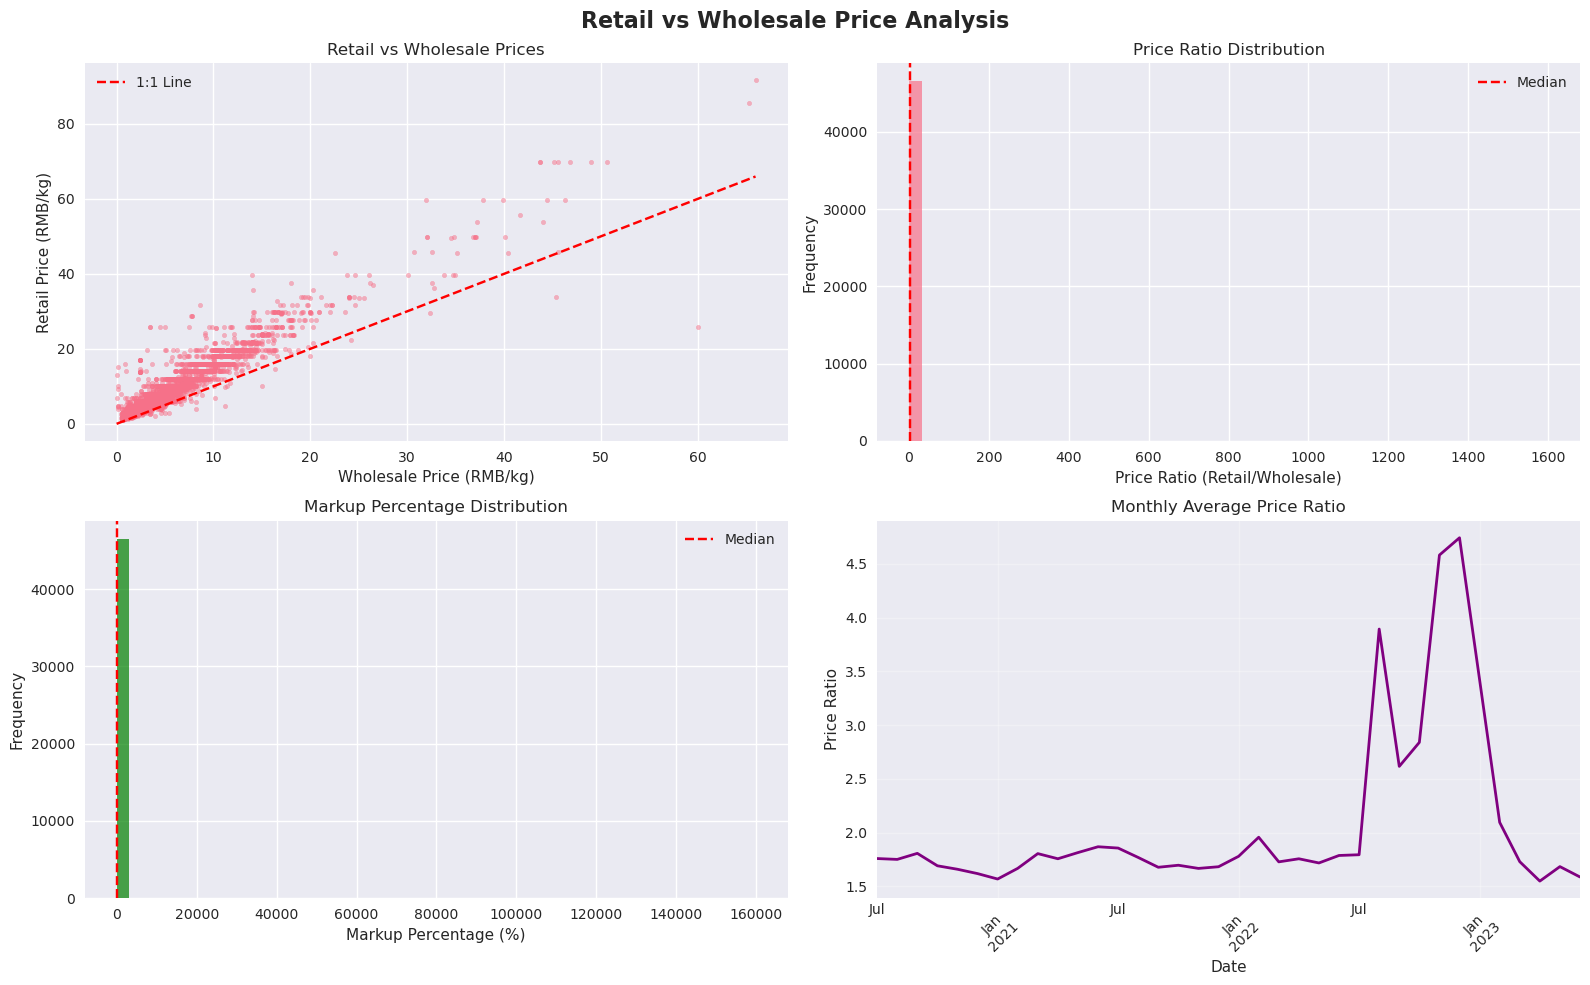

In [16]:
# Analyze price relationships (retail vs wholesale)
if 'sales' in data and 'wholesale' in data:
    print("\n RETAIL vs WHOLESALE PRICE ANALYSIS")
    print("="*50)
    
    # Create daily sales aggregates
    daily_sales = data['sales'].groupby(['Date', 'Item Code']).agg({
        'Unit Selling Price (RMB/kg)': 'mean',
        'Quantity Sold (kilo)': 'sum'
    }).reset_index()
    daily_sales.columns = ['Date', 'Item Code', 'Retail_Price', 'Quantity']
    
    # Merge with wholesale prices
    price_comparison = daily_sales.merge(
        data['wholesale'][['Date', 'Item Code', 'Wholesale Price (RMB/kg)']],
        on=['Date', 'Item Code'],
        how='inner'
    )
    
    if len(price_comparison) > 0:
        # Calculate price metrics
        price_comparison['Price_Ratio'] = price_comparison['Retail_Price'] / price_comparison['Wholesale Price (RMB/kg)']
        price_comparison['Price_Markup'] = price_comparison['Retail_Price'] - price_comparison['Wholesale Price (RMB/kg)']
        price_comparison['Markup_Percentage'] = (price_comparison['Price_Markup'] / price_comparison['Wholesale Price (RMB/kg)']) * 100
        
        print(f"Records with both retail and wholesale prices: {len(price_comparison):,}")
        print(f"\nPrice Ratio Statistics (Retail/Wholesale):")
        ratio_stats = price_comparison['Price_Ratio'].describe()
        for stat, value in ratio_stats.items():
            print(f"  {stat}: {value:.2f}")
        
        print(f"\nMarkup Percentage Statistics:")
        markup_stats = price_comparison['Markup_Percentage'].describe()
        for stat, value in markup_stats.items():
            print(f"  {stat}: {value:.1f}%")
        
        # Visualize price relationships
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Retail vs Wholesale Price Analysis', fontsize=16, fontweight='bold')
        
        # 1. Scatter plot: Retail vs Wholesale prices
        sample_data = price_comparison.sample(min(5000, len(price_comparison)))
        axes[0, 0].scatter(sample_data['Wholesale Price (RMB/kg)'], sample_data['Retail_Price'], 
                          alpha=0.5, s=10)
        axes[0, 0].plot([0, sample_data['Wholesale Price (RMB/kg)'].max()], 
                       [0, sample_data['Wholesale Price (RMB/kg)'].max()], 
                       'r--', label='1:1 Line')
        axes[0, 0].set_xlabel('Wholesale Price (RMB/kg)')
        axes[0, 0].set_ylabel('Retail Price (RMB/kg)')
        axes[0, 0].set_title('Retail vs Wholesale Prices')
        axes[0, 0].legend()
        
        # 2. Price ratio distribution
        price_comparison['Price_Ratio'].hist(bins=50, ax=axes[0, 1], alpha=0.7)
        axes[0, 1].set_xlabel('Price Ratio (Retail/Wholesale)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Price Ratio Distribution')
        axes[0, 1].axvline(price_comparison['Price_Ratio'].median(), 
                          color='red', linestyle='--', label='Median')
        axes[0, 1].legend()
        
        # 3. Markup percentage distribution
        price_comparison['Markup_Percentage'].hist(bins=50, ax=axes[1, 0], alpha=0.7, color='green')
        axes[1, 0].set_xlabel('Markup Percentage (%)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Markup Percentage Distribution')
        axes[1, 0].axvline(price_comparison['Markup_Percentage'].median(), 
                          color='red', linestyle='--', label='Median')
        axes[1, 0].legend()
        
        # 4. Price ratio over time
        monthly_ratio = price_comparison.groupby(price_comparison['Date'].dt.to_period('M'))['Price_Ratio'].mean()
        monthly_ratio.plot(ax=axes[1, 1], color='purple', linewidth=2)
        axes[1, 1].set_title('Monthly Average Price Ratio')
        axes[1, 1].set_ylabel('Price Ratio')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No overlapping records found between retail and wholesale prices.")

## 8. Time Series Analysis

In [17]:
# Time series analysis for seasonal patterns
if 'sales' in data:
    print(" TIME SERIES ANALYSIS")
    print("="*50)
    
    # Create daily aggregated time series
    daily_metrics = data['sales'].groupby('Date').agg({
        'Unit Selling Price (RMB/kg)': 'mean',
        'Quantity Sold (kilo)': 'sum',
        'Item Code': 'count'  # Number of transactions
    }).reset_index()
    daily_metrics.columns = ['Date', 'Avg_Price', 'Total_Quantity', 'Transaction_Count']
    daily_metrics['Revenue'] = daily_metrics['Avg_Price'] * daily_metrics['Total_Quantity']
    
    # Set date as index for time series analysis
    daily_metrics.set_index('Date', inplace=True)
    daily_metrics = daily_metrics.sort_index()
    
    print(f"Time series data: {len(daily_metrics)} days")
    print(f"Date range: {daily_metrics.index.min()} to {daily_metrics.index.max()}")
    
    # Basic time series statistics
    print(f"\nDaily Metrics Summary:")
    print(daily_metrics.describe())

 TIME SERIES ANALYSIS
Time series data: 1085 days
Date range: 2020-07-01 00:00:00 to 2023-06-30 00:00:00

Daily Metrics Summary:
         Avg_Price  Total_Quantity  Transaction_Count       Revenue
count  1085.000000     1085.000000        1085.000000   1085.000000
mean      8.775083      434.079187         809.680184   3806.432519
std       1.781457      208.493411         320.958490   2246.900521
min       4.258974       64.243000          74.000000    301.884621
25%       7.695071      303.421000         585.000000   2509.317978
50%       8.610526      397.806000         759.000000   3407.775426
75%       9.789098      514.592000         995.000000   4470.575834
max      17.916653     2483.880000        3747.000000  37618.701149



 SEASONAL DECOMPOSITION


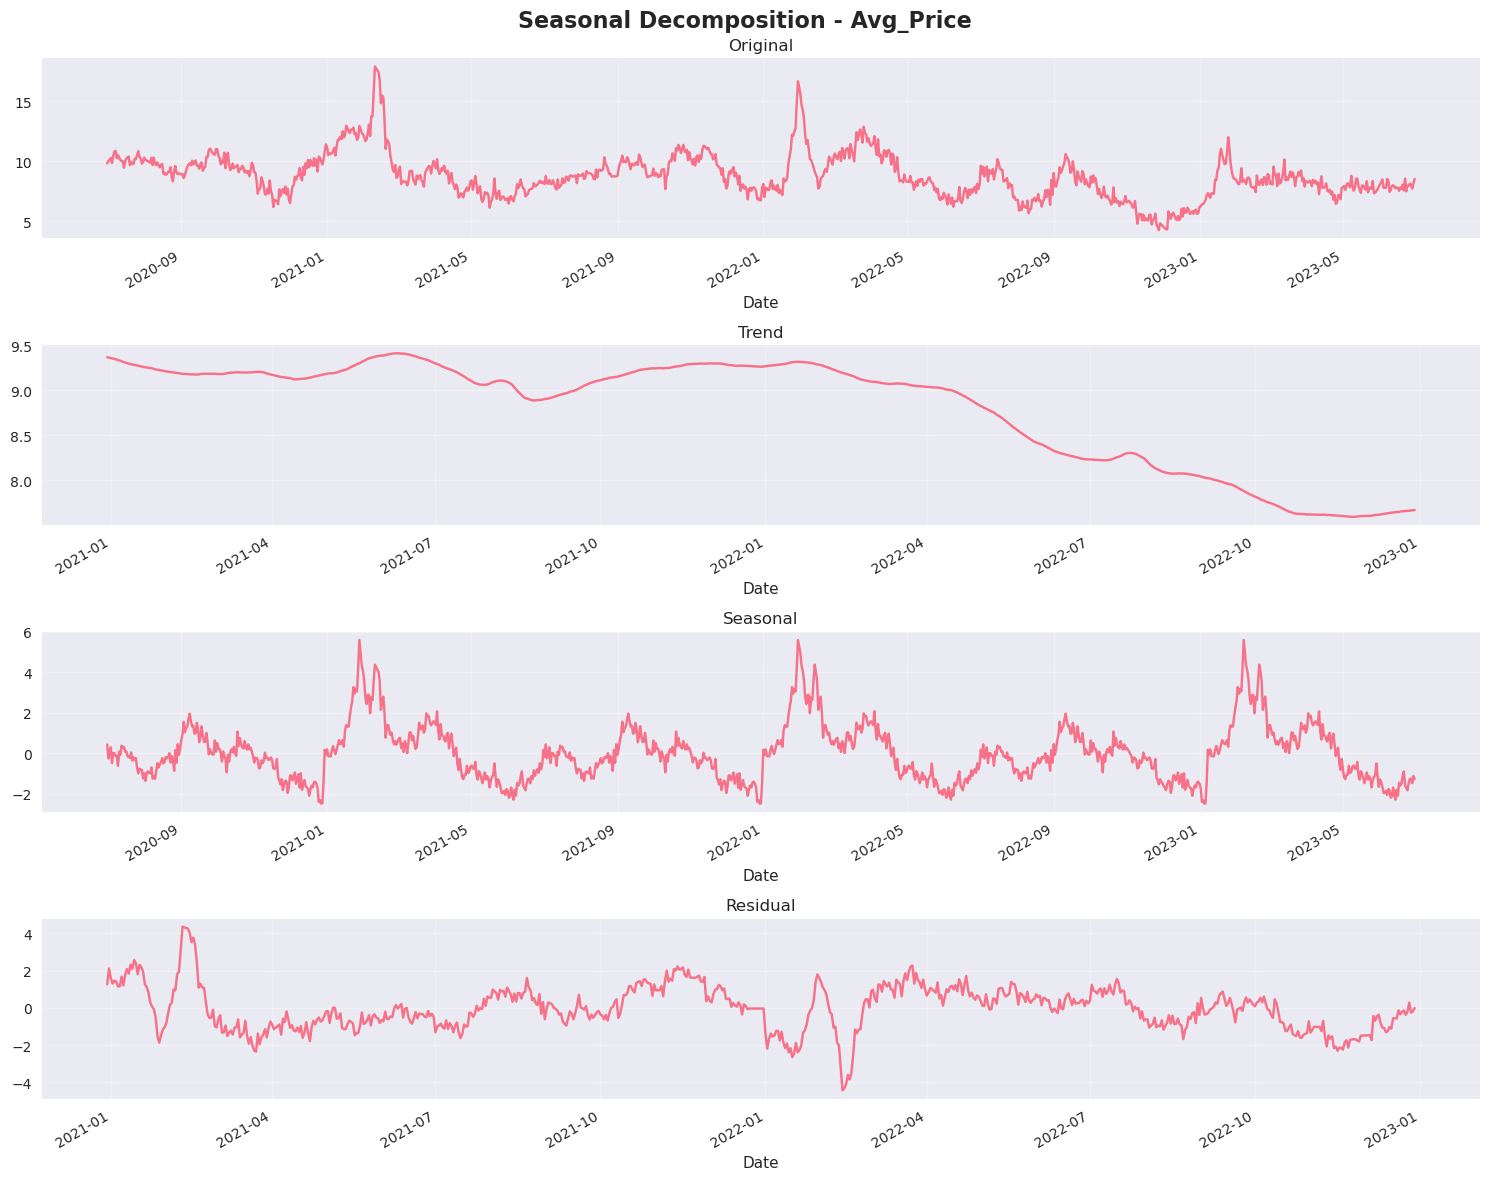


Avg_Price - Seasonality Strength: 0.573
Avg_Price - Trend Strength: 0.301


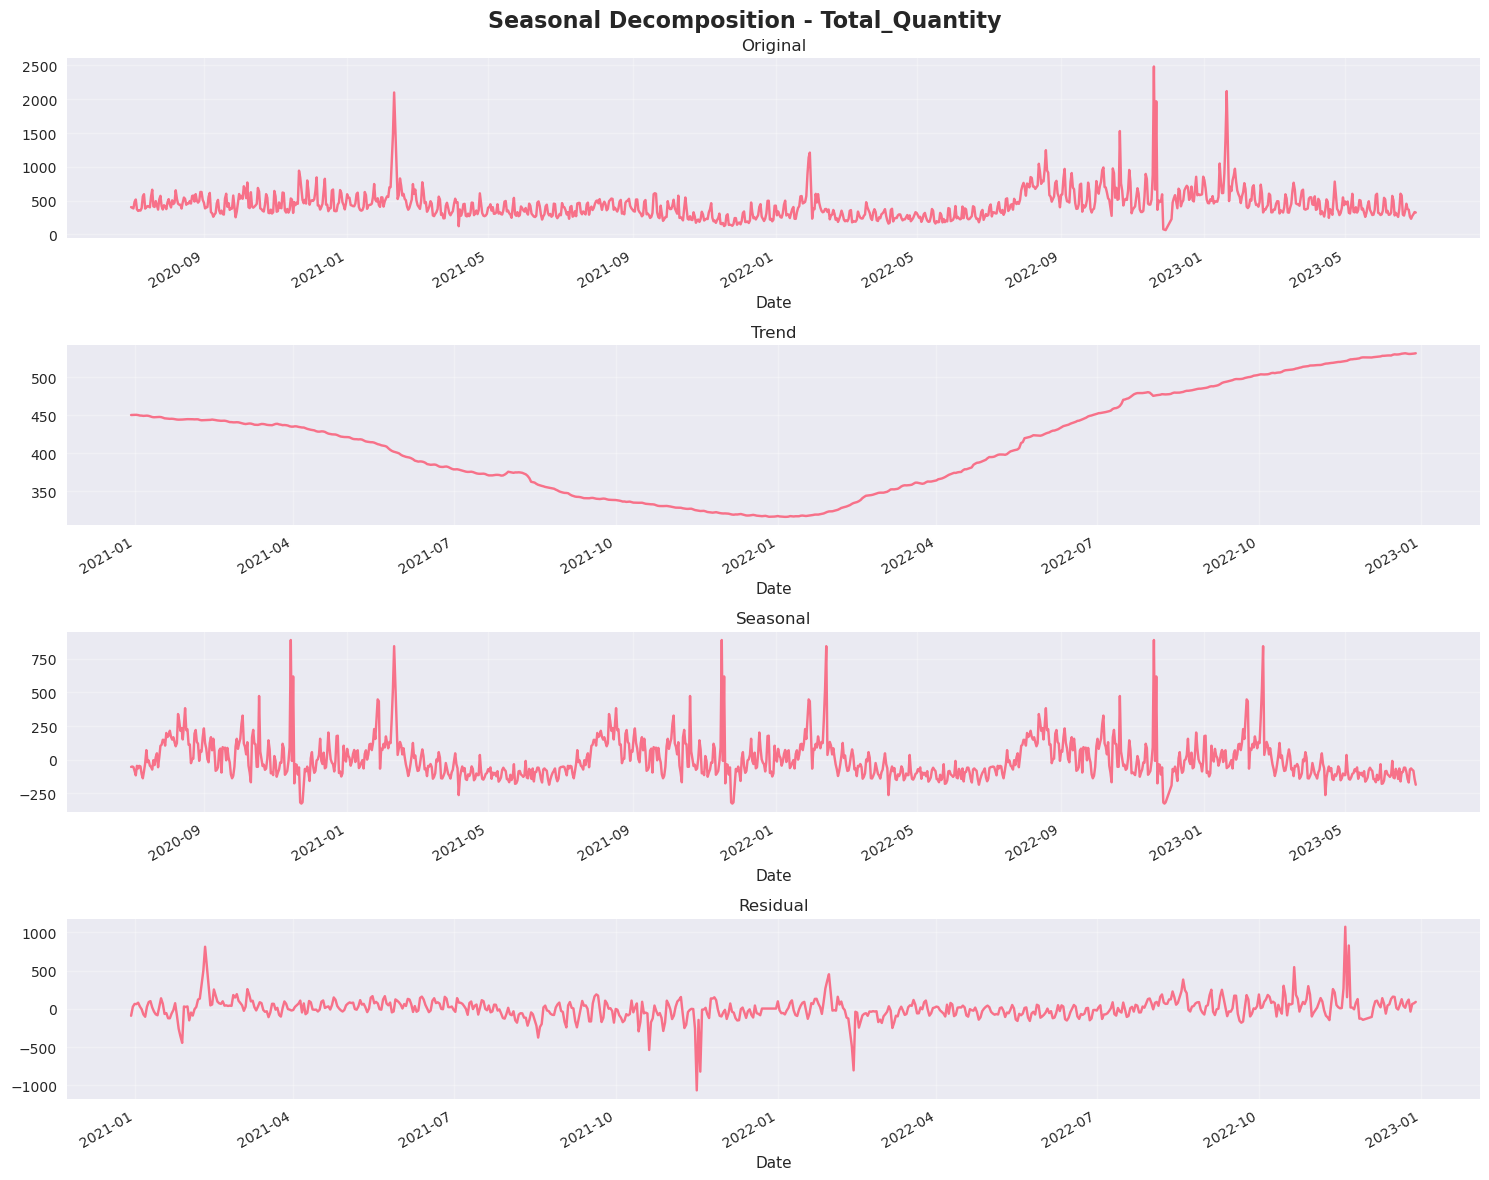


Total_Quantity - Seasonality Strength: 0.528
Total_Quantity - Trend Strength: 0.334


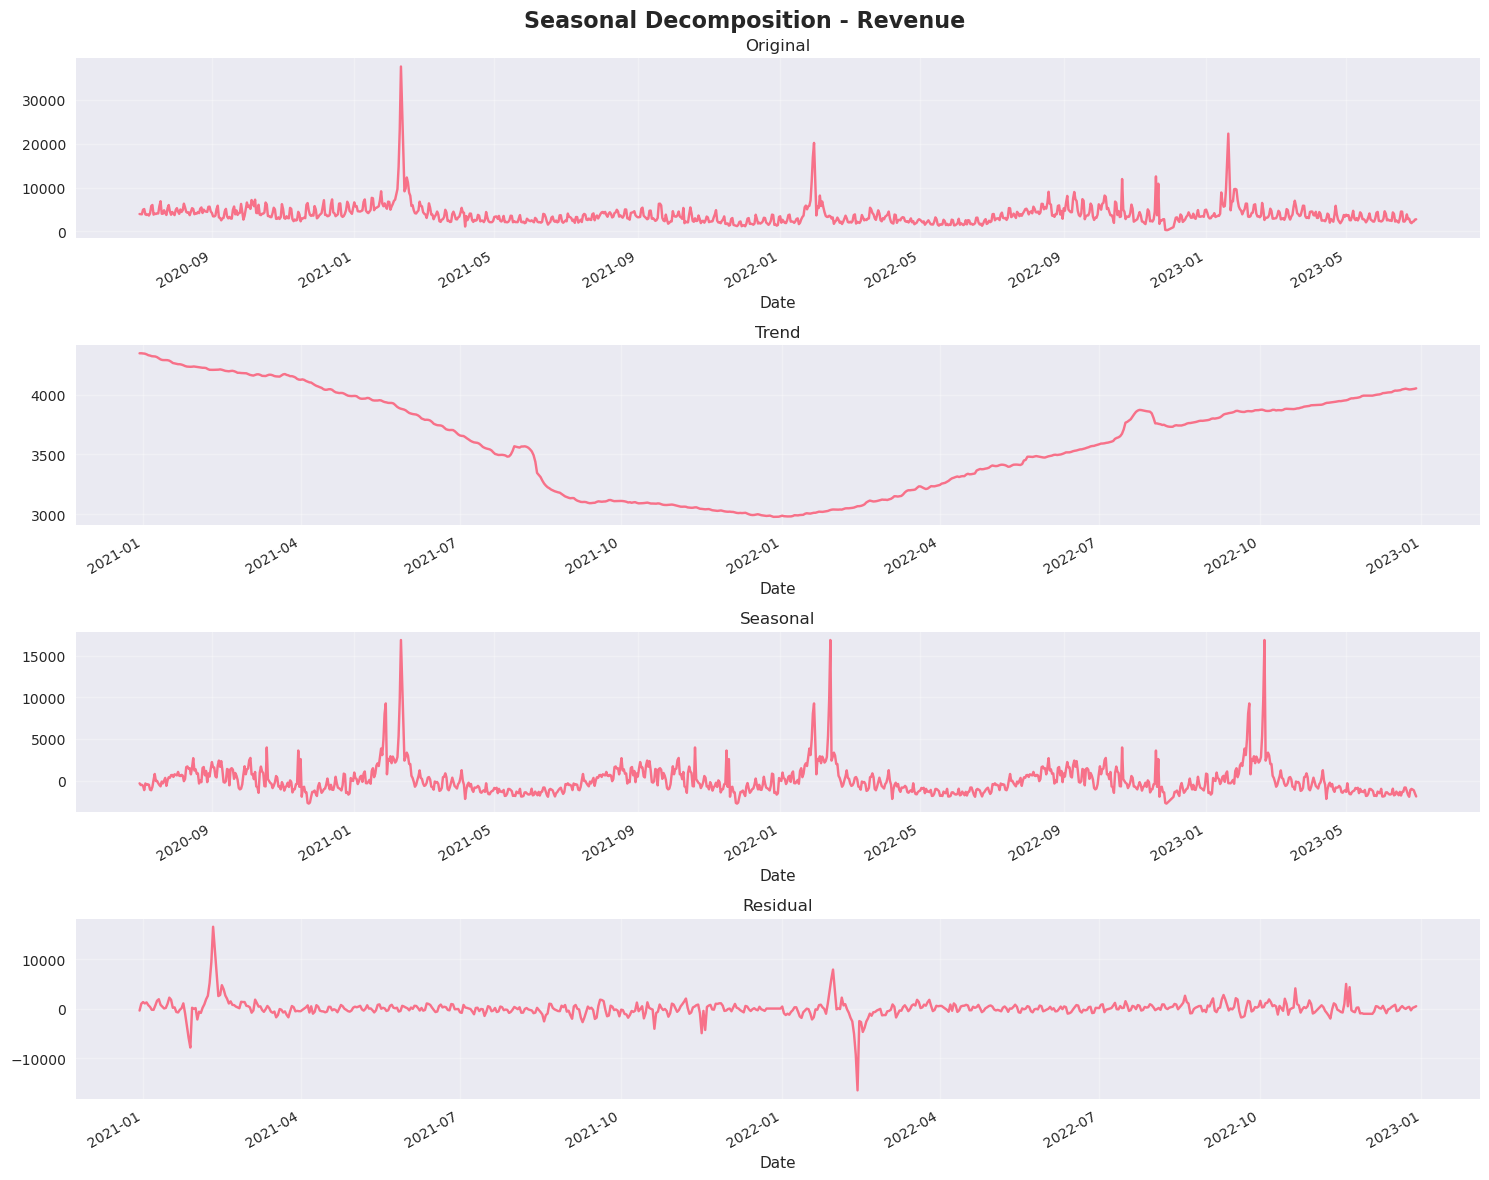


Revenue - Seasonality Strength: 0.582
Revenue - Trend Strength: 0.151


In [18]:
# Seasonal decomposition
if 'sales' in data and len(daily_metrics) > 365:
    print("\n SEASONAL DECOMPOSITION")
    print("="*40)
    
    # Decompose the main metrics
    metrics_to_decompose = ['Avg_Price', 'Total_Quantity', 'Revenue']
    
    for metric in metrics_to_decompose:
        if metric in daily_metrics.columns:
            # Fill missing values for decomposition
            ts_data = daily_metrics[metric].fillna(method='ffill').fillna(method='bfill')
            
            if len(ts_data.dropna()) > 730:  # At least 2 years of data
                try:
                    # Perform seasonal decomposition
                    decomposition = seasonal_decompose(ts_data, model='additive', period=365)
                    
                    # Plot decomposition
                    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
                    fig.suptitle(f'Seasonal Decomposition - {metric}', fontsize=16, fontweight='bold')
                    
                    decomposition.observed.plot(ax=axes[0], title='Original')
                    decomposition.trend.plot(ax=axes[1], title='Trend')
                    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
                    decomposition.resid.plot(ax=axes[3], title='Residual')
                    
                    for ax in axes:
                        ax.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # Calculate seasonality strength
                    seasonal_strength = 1 - (decomposition.resid.var() / (decomposition.seasonal + decomposition.resid).var())
                    trend_strength = 1 - (decomposition.resid.var() / (decomposition.trend + decomposition.resid).var())
                    
                    print(f"\n{metric} - Seasonality Strength: {seasonal_strength:.3f}")
                    print(f"{metric} - Trend Strength: {trend_strength:.3f}")
                    
                except Exception as e:
                    print(f"Could not decompose {metric}: {e}")
            else:
                print(f"Insufficient data for seasonal decomposition of {metric}")


📊 AUTOCORRELATION ANALYSIS


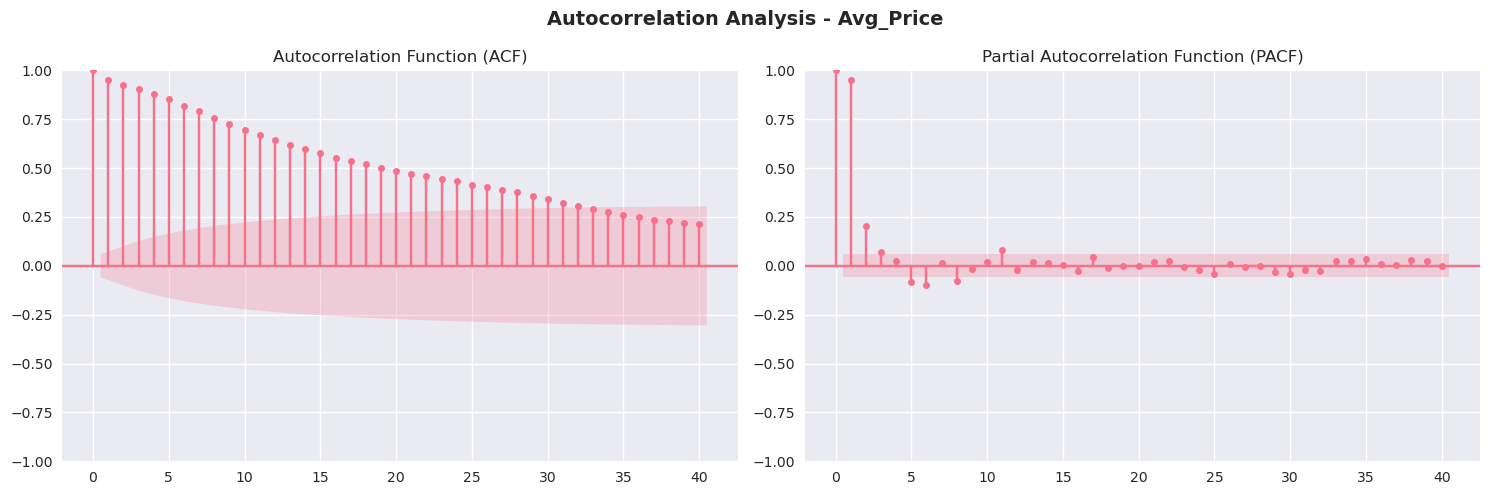

Key Autocorrelations for Avg_Price:
  Lag 1 (daily): 0.953
  Lag 7 (weekly): 0.792
  Lag 30 (monthly): 0.346


In [20]:
# Autocorrelation analysis
if 'sales' in data and len(daily_metrics) > 100:
    print("\n📊 AUTOCORRELATION ANALYSIS")
    print("="*40)
    
    # Select a key metric for autocorrelation analysis
    target_metric = 'Avg_Price'
    if target_metric in daily_metrics.columns:
        ts_data = daily_metrics[target_metric].fillna(method='ffill').dropna()
        
        if len(ts_data) > 50:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            fig.suptitle(f'Autocorrelation Analysis - {target_metric}', fontsize=14, fontweight='bold')
            
            # ACF plot
            plot_acf(ts_data, lags=min(40, len(ts_data)//4), ax=ax1)
            ax1.set_title('Autocorrelation Function (ACF)')
            
            # PACF plot
            plot_pacf(ts_data, lags=min(40, len(ts_data)//4), ax=ax2)
            ax2.set_title('Partial Autocorrelation Function (PACF)')
            
            plt.tight_layout()
            plt.show()
            
            # Calculate key autocorrelations
            lag_1_corr = ts_data.autocorr(lag=1)
            lag_7_corr = ts_data.autocorr(lag=7)
            lag_30_corr = ts_data.autocorr(lag=30)
            
            print(f"Key Autocorrelations for {target_metric}:")
            print(f"  Lag 1 (daily): {lag_1_corr:.3f}")
            print(f"  Lag 7 (weekly): {lag_7_corr:.3f}")
            print(f"  Lag 30 (monthly): {lag_30_corr:.3f}")

## 9. Market Insights and Business Intelligence

In [20]:
# Generate market insights
print(" MARKET INSIGHTS & BUSINESS INTELLIGENCE")
print("="*60)

insights = []

# 1. Top performing items by revenue
if 'sales' in data and 'items' in data:
    sales_with_names = data['sales'].merge(
        data['items'][['Item Code', 'Item Name', 'Category Name']], 
        on='Item Code', 
        how='left'
    )
    
    sales_with_names['Revenue'] = (
        sales_with_names['Quantity Sold (kilo)'] * 
        sales_with_names['Unit Selling Price (RMB/kg)']
    )
    
    top_revenue_items = sales_with_names.groupby(['Item Code', 'Item Name', 'Category Name'])['Revenue'].sum().sort_values(ascending=False)
    
    insights.append(" TOP REVENUE GENERATING ITEMS:")
    for i, ((item_code, item_name, category), revenue) in enumerate(top_revenue_items.head(10).items(), 1):
        insights.append(f"  {i}. {item_name} ({category}): ¥{revenue:,.2f}")

# 2. Most volatile prices
if 'wholesale' in data and 'items' in data:
    wholesale_with_names = data['wholesale'].merge(
        data['items'][['Item Code', 'Item Name']], 
        on='Item Code', 
        how='left'
    )
    
    price_volatility = wholesale_with_names.groupby(['Item Code', 'Item Name'])['Wholesale Price (RMB/kg)'].agg(['mean', 'std'])
    price_volatility['cv'] = price_volatility['std'] / price_volatility['mean']  # Coefficient of variation
    price_volatility = price_volatility.sort_values('cv', ascending=False)
    
    insights.append("\n MOST PRICE-VOLATILE ITEMS:")
    for i, (item_code, item_name) in enumerate(price_volatility.head(5).index, 1):
        cv = price_volatility.loc[(item_code, item_name), 'cv']
        insights.append(f"  {i}. {item_name}: CV = {cv:.3f}")

# 3. Seasonal patterns
if 'sales' in data:
    sales_seasonal = data['sales'].copy()
    sales_seasonal['Month'] = sales_seasonal['Date'].dt.month
    sales_seasonal['Season'] = sales_seasonal['Month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    })
    
    seasonal_revenue = sales_seasonal.groupby('Season').apply(
        lambda x: (x['Quantity Sold (kilo)'] * x['Unit Selling Price (RMB/kg)']).sum()
    ).sort_values(ascending=False)
    
    insights.append("\n SEASONAL REVENUE PATTERNS:")
    for i, (season, revenue) in enumerate(seasonal_revenue.items(), 1):
        insights.append(f"  {i}. {season}: ¥{revenue:,.2f}")

# 4. Loss rate impact
if 'loss_rates' in data and 'sales' in data:
    sales_with_loss = data['sales'].merge(
        data['loss_rates'][['Item Code', 'Loss Rate (%)']], 
        on='Item Code', 
        how='left'
    )
    
    sales_with_loss['Revenue'] = (
        sales_with_loss['Quantity Sold (kilo)'] * 
        sales_with_loss['Unit Selling Price (RMB/kg)']
    )
    
    sales_with_loss['Loss Rate (%)'].fillna(sales_with_loss['Loss Rate (%)'].mean(), inplace=True)
    sales_with_loss['Potential_Loss_Value'] = (
        sales_with_loss['Revenue'] * sales_with_loss['Loss Rate (%)'] / 100
    )
    
    total_potential_loss = sales_with_loss['Potential_Loss_Value'].sum()
    total_revenue = sales_with_loss['Revenue'].sum()
    
    insights.append(f"\n LOSS RATE IMPACT:")
    insights.append(f"  Total Potential Loss: ¥{total_potential_loss:,.2f}")
    insights.append(f"  Loss as % of Revenue: {total_potential_loss/total_revenue*100:.2f}%")

# Print all insights
for insight in insights:
    print(insight)

 MARKET INSIGHTS & BUSINESS INTELLIGENCE
 TOP REVENUE GENERATING ITEMS:
  1. Broccoli (Cabbage): ¥269,874.25
  2. Net Lotus Root (1) (Aquatic Tuberous Vegetables): ¥211,652.10
  3. Xixia Mushroom (1) (Edible Mushroom): ¥211,198.39
  4. Wuhu Green Pepper (1) (Capsicum): ¥205,113.70
  5. Yunnan Shengcai (Flower/Leaf Vegetables): ¥129,756.96
  6. Eggplant (2) (Solanum): ¥117,729.42
  7. Paopaojiao (Jingpin) (Capsicum): ¥95,568.63
  8. Luosi Pepper (Capsicum): ¥82,009.35
  9. Yunnan Lettuces (Flower/Leaf Vegetables): ¥70,665.11
  10. Honghu Lotus Root Powder (Fenou) (Aquatic Tuberous Vegetables): ¥64,339.60

 MOST PRICE-VOLATILE ITEMS:
  1. Millet Pepper (Bag): CV = 0.946
  2. Perilla: CV = 0.866
  3. Xixia Black Mushroom (2): CV = 0.864
  4. Agaricus Bisporus (Bag): CV = 0.842
  5. Zhuyecai (Bag): CV = 0.815

 SEASONAL REVENUE PATTERNS:
  1. Winter: ¥991,995.12
  2. Autumn: ¥852,164.39
  3. Summer: ¥848,870.39
  4. Spring: ¥676,736.57

 LOSS RATE IMPACT:
  Total Potential Loss: ¥335,804.9

## 10. Data Quality Recommendations

In [23]:
# Generate data quality recommendations
print("\n DATA QUALITY RECOMMENDATIONS")
print("="*50)

recommendations = []

# Check for data issues and generate recommendations
if 'sales' in data:
    sales_df = data['sales']
    
    # Check for negative prices or quantities
    negative_prices = (sales_df['Unit Selling Price (RMB/kg)'] <= 0).sum()
    negative_quantities = (sales_df['Quantity Sold (kilo)'] <= 0).sum()
    
    if negative_prices > 0:
        recommendations.append(f" Found {negative_prices} records with negative/zero prices - investigate pricing errors")
    
    if negative_quantities > 0:
        recommendations.append(f" Found {negative_quantities} records with negative/zero quantities - review transaction logic")
    
    # Check for extreme outliers
    price_q99 = sales_df['Unit Selling Price (RMB/kg)'].quantile(0.99)
    extreme_prices = (sales_df['Unit Selling Price (RMB/kg)'] > price_q99 * 3).sum()
    
    if extreme_prices > 0:
        recommendations.append(f" Found {extreme_prices} records with extreme prices (>3x 99th percentile) - validate data entry")

# Check missing data patterns
for name, df in data.items():
    missing_pct = (df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100)
    if missing_pct > 5:
        recommendations.append(f"  {name} dataset has {missing_pct:.1f}% missing data - consider imputation strategies")

# Check date coverage
if 'sales' in data and 'wholesale' in data:
    sales_date_range = (data['sales']['Date'].max() - data['sales']['Date'].min()).days
    wholesale_date_range = (data['wholesale']['Date'].max() - data['wholesale']['Date'].min()).days
    
    if abs(sales_date_range - wholesale_date_range) > 30:
        recommendations.append(f"  Date range mismatch between sales ({sales_date_range} days) and wholesale ({wholesale_date_range} days) data")

# General recommendations
recommendations.extend([
    " Implement automated data validation pipelines",
    " Set up monitoring for price and quantity anomalies",
    " Establish data refresh schedules for real-time forecasting",
    " Create data lineage tracking for audit purposes",
    " Implement schema validation for incoming data"
])

for i, rec in enumerate(recommendations, 1):
    print(f"{i:2d}. {rec}")


 DATA QUALITY RECOMMENDATIONS
 1.  Found 461 records with negative/zero quantities - review transaction logic
 2.  Found 44 records with extreme prices (>3x 99th percentile) - validate data entry
 3.  Implement automated data validation pipelines
 4.  Set up monitoring for price and quantity anomalies
 5.  Establish data refresh schedules for real-time forecasting
 6.  Create data lineage tracking for audit purposes
 7.  Implement schema validation for incoming data


## 11. Feature Engineering Preparation

In [24]:
# Prepare for feature engineering
print("\n FEATURE ENGINEERING PREPARATION")
print("="*50)

feature_opportunities = [
    " Temporal Features:",
    "   - Seasonal indicators (spring, summer, autumn, winter)",
    "   - Holiday effects (Chinese New Year, National Day, etc.)",
    "   - Day of week and month patterns",
    "   - Cyclical encoding for seasonal patterns",
    
    "\n Price Features:",
    "   - Moving averages (7, 14, 30 day windows)",
    "   - Price volatility measures",
    "   - Retail-wholesale price ratios and markups",
    "   - Price change rates and momentum",
    
    "\n Lag Features:",
    "   - Price lags (1, 7, 14, 30 days)",
    "   - Quantity lags for demand patterns",
    "   - Revenue and transaction count lags",
    
    "\n Category Features:",
    "   - Category-level aggregations",
    "   - Item's market share within category",
    "   - Category performance metrics",
    
    "\n External Features:",
    "   - USD/CNY exchange rate (for import-dependent items)",
    "   - Exchange rate volatility",
    "   - Economic indicators (if available)",
    
    "\n Loss Rate Features:",
    "   - Item-specific loss rates",
    "   - Loss-adjusted supply calculations",
    "   - Loss rate categories (low, medium, high)",
    
    "\n Interaction Features:",
    "   - Price-quantity interactions",
    "   - Seasonal-price interactions",
    "   - Category-season interactions"
]

for opportunity in feature_opportunities:
    print(opportunity)

print("\n Next Steps:")
print("1. Run feature engineering pipeline with src/data_processing/feature_engineering.py")
print("2. Validate engineered features")
print("3. Proceed to model training and evaluation")
print("4. Set up automated MLOps pipeline")


 FEATURE ENGINEERING PREPARATION
 Temporal Features:
   - Seasonal indicators (spring, summer, autumn, winter)
   - Holiday effects (Chinese New Year, National Day, etc.)
   - Day of week and month patterns
   - Cyclical encoding for seasonal patterns

 Price Features:
   - Moving averages (7, 14, 30 day windows)
   - Price volatility measures
   - Retail-wholesale price ratios and markups
   - Price change rates and momentum

 Lag Features:
   - Price lags (1, 7, 14, 30 days)
   - Quantity lags for demand patterns
   - Revenue and transaction count lags

 Category Features:
   - Category-level aggregations
   - Item's market share within category
   - Category performance metrics

 External Features:
   - USD/CNY exchange rate (for import-dependent items)
   - Exchange rate volatility
   - Economic indicators (if available)

 Loss Rate Features:
   - Item-specific loss rates
   - Loss-adjusted supply calculations
   - Loss rate categories (low, medium, high)

 Interaction Features:
 

## Summary

This exploratory data analysis has provided comprehensive insights into the Chinese produce market data:

### Key Findings:
1. **Data Quality**: Overall good quality with manageable missing data
2. **Seasonal Patterns**: Clear seasonal trends in prices and quantities
3. **Price Relationships**: Consistent retail-wholesale price relationships
4. **Loss Rate Impact**: Significant potential revenue impact from losses
5. **Category Diversity**: Wide range of produce categories with varying patterns

### Business Implications:
- Seasonal forecasting models will be crucial for inventory planning
- Price volatility analysis can inform risk management strategies
- Loss rate optimization presents revenue recovery opportunities
- Category-specific models may improve forecast accuracy

### Technical Readiness:
- Data is suitable for machine learning applications
- Feature engineering pipeline can leverage temporal and cross-dataset patterns
- Multiple forecasting horizons can be supported
- Real-time deployment feasible with current data structure

**Ready to proceed with feature engineering and model development!**